<a href="https://colab.research.google.com/github/rakesh-sengupta/quantum-self-attention/blob/main/quantum_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raw quantum scores:
 [[1.    0.999 1.    0.999]
 [0.999 1.    0.999 0.999]
 [1.    0.999 1.    0.999]
 [0.999 0.999 0.999 1.   ]]

Poly‐QSVT approx weights:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Classical softmax weights:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Quantum‐poly outputs vs classical:
q0 QOUT: [0.809 0.537 0.235 0.034]   COUT: [0.809 0.537 0.235 0.034]
q1 QOUT: [0.809 0.537 0.235 0.034]   COUT: [0.809 0.537 0.235 0.034]
q2 QOUT: [0.809 0.537 0.235 0.034]   COUT: [0.809 0.537 0.235 0.034]
q3 QOUT: [0.809 0.537 0.235 0.034]   COUT: [0.809 0.537 0.235 0.034]

Expected data state probabilities: [0.655 0.288 0.055 0.001]
Quantum data state probabilities: [0.842 0.029 0.012 0.117]


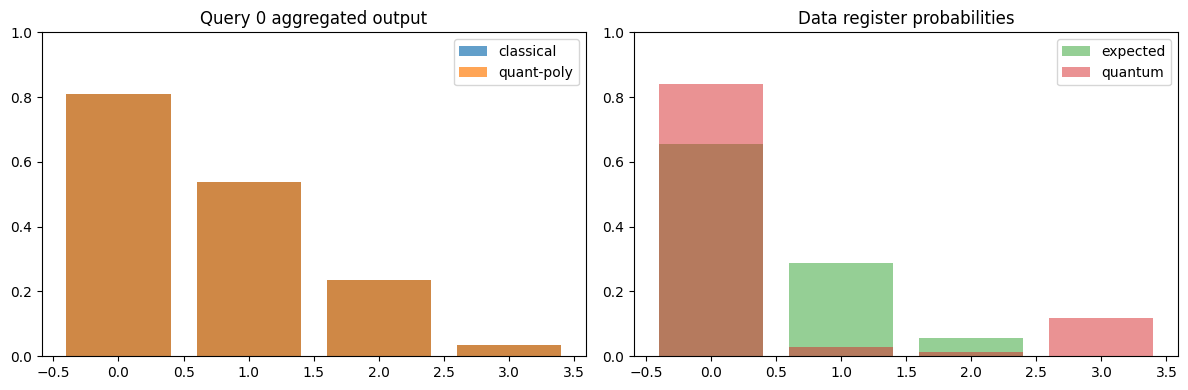

In [25]:
!pip install pennylane scikit-learn --quiet

import pennylane as qml
from pennylane import numpy as np
import numpy as onp
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import math

# Fix seed
np.random.seed(42)

# -----------------------------------------------------------------------------
# 2. Load & normalize Iris (use first T=4 samples, d=4 features)
# -----------------------------------------------------------------------------
iris = load_iris()
X = iris.data[:4]      # shape (4,4)
X = normalize(X, axis=1)

Q_data, K_data, V_data = X, X.copy(), X.copy()
T, d = 4, 4

# -----------------------------------------------------------------------------
# 3. Polynomial approximation of exp(x) on [a,b] → map to [-1,1]
#    We choose a≈min(scores), b≈max(scores) after computing scores,
#    then approximate exp by Chebyshev fit of degree 3.
# -----------------------------------------------------------------------------
def poly_exp_approx(scores, degree=3):
    """Fit & eval a degree-d Chebyshev polynomial to exp(x) on [min,max]."""
    # 1) Bring to a plain NumPy array
    s = onp.array(scores, dtype=float)
    a, b = s.min(), s.max()
    # 2) Map s → t in [-1,1]
    t = (2*s - (b + a)) / (b - a)

    # 3) Choose Chebyshev nodes in [-1,1]
    M = 100
    nodes = onp.cos((2*onp.arange(M)+1)/(2*M)*onp.pi)
    # Map nodes → original x‐domain
    xs = ((b - a)*nodes + (b + a)) / 2
    ys = onp.exp(xs)

    # 4) Fit a Chebyshev polynomial p(t) ≈ exp(x)
    coeffs = onp.polynomial.chebyshev.chebfit(nodes, ys, deg=degree)

    # 5) Evaluate p at our t‐values
    approx = onp.polynomial.chebyshev.chebval(t, coeffs)
    return approx  # still a plain NumPy array

# -----------------------------------------------------------------------------
# 4. Quantum subroutines
# -----------------------------------------------------------------------------
n_data = 2        # to embed d=4 dim
n_ancilla = 1
hadamard_dev = qml.device("default.qubit", wires=n_data + n_ancilla, shots=None)

def amplitude_encode(vec, wires):
    vec = np.array(vec, float)
    norm = np.linalg.norm(vec)
    if norm==0:
        raise ValueError("Zero vector")
    qml.AmplitudeEmbedding(features=vec/norm, wires=wires, normalize=False)

@qml.qnode(hadamard_dev)
def hadamard_test(Uq, Uk):
    anc = n_data
    qml.Hadamard(wires=anc)
    def W():
        Uq(); qml.adjoint(Uk)()
    qml.ctrl(W, control=anc)()
    qml.Hadamard(wires=anc)
    return qml.expval(qml.PauliZ(wires=anc))

def overlap(q_vec, k_vec):
    def Uq(): amplitude_encode(q_vec, wires=range(n_data))
    def Uk(): amplitude_encode(k_vec, wires=range(n_data))
    return hadamard_test(Uq, Uk)

# -----------------------------------------------------------------------------
# 5. Build quantum scores matrix
# -----------------------------------------------------------------------------
scores = np.zeros((T,T))
for i in range(T):
    for j in range(T):
        scores[i,j] = overlap(Q_data[i], K_data[j])

print("Raw quantum scores:\n", np.round(scores,3))

# -----------------------------------------------------------------------------
# 6. Polynomial‐approx softmax → attention weights
# -----------------------------------------------------------------------------
# approximate exp
scores_flat = scores.flatten()
exp_approx = poly_exp_approx(scores_flat, degree=3).reshape(T,T)
# normalize rows
weights_q = exp_approx / np.sum(exp_approx, axis=1, keepdims=True)
print("\nPoly‐QSVT approx weights:\n", np.round(weights_q,3))

# classical softmax baseline for comparison
def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)
weights_cl = np.array([softmax(scores[i]) for i in range(T)])
print("\nClassical softmax weights:\n", np.round(weights_cl,3))

# -----------------------------------------------------------------------------
# 7. Classical aggregation
# -----------------------------------------------------------------------------
out_q = [ sum(weights_q[i,j]*V_data[j] for j in range(T)) for i in range(T) ]
out_cl = [ sum(weights_cl[i,j]*V_data[j] for j in range(T)) for i in range(T) ]
print("\nQuantum‐poly outputs vs classical:")
for i in range(T):
    print(f"q{i} QOUT:", np.round(out_q[i],3),
          "  COUT:", np.round(out_cl[i],3))

# -------------------------------------------------------------------------
# 8. CORRECTED: Quantum aggregation without uncompute
# -------------------------------------------------------------------------
n_index = math.ceil(math.log2(T))
agg_dev = qml.device("default.qubit", wires=n_index + n_data, shots=None)

@qml.qnode(agg_dev)
def agg_circuit(weights, V_states):
    idx  = list(range(n_index))
    data = list(range(n_index, n_index+n_data))

    # 1) Prepare index register: ∑ⱼ √wⱼ |j⟩
    amp = np.sqrt(weights)
    qml.AmplitudeEmbedding(features=amp/np.linalg.norm(amp),
                           wires=idx, normalize=True)

    # 2) Controlled state preparation: apply U_vⱼ when index=j
    for j in range(T):
        def Uvj(): amplitude_encode(V_states[j], wires=data)
        ctrl_bin = format(j, f"0{n_index}b")
        qml.ctrl(Uvj, control=idx, control_values=ctrl_bin)()

    return qml.state()

# Run for first query
state0 = agg_circuit(weights_q[0].tolist(), V_data.tolist())

# Extract the data register state by tracing out index
# Convert statevector to density matrix
density_matrix = np.outer(state0, np.conj(state0))

# Partial trace over index register
idx_wires = list(range(n_index))
data_wires = list(range(n_index, n_index+n_data))

# Calculate reduced density matrix for data register
data_state = np.zeros((2**n_data, 2**n_data), dtype=complex)
for i in range(2**n_data):
    for j in range(2**n_data):
        for k in range(2**n_index):
            idx = k * (2**n_data) + i
            jdx = k * (2**n_data) + j
            data_state[i, j] += density_matrix[idx, jdx]

# Get the diagonal (probabilities) for visualization
data_probs = np.real(np.diag(data_state))

# Expected output state (normalized)
out0 = onp.array(out_q[0])
data_state_expected = out0 / onp.linalg.norm(out0)
expected_probs = np.square(np.abs(data_state_expected))

print("\nExpected data state probabilities:", np.round(expected_probs, 3))
print("Quantum data state probabilities:", np.round(data_probs, 3))

# -----------------------------------------------------------------------------
# 9. Visualization
# -----------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Classical vs quantum-poly outputs
axs[0].bar(range(d), out_cl[0], color='C0', alpha=0.7, label='classical')
axs[0].bar(range(d), out_q[0], color='C1', alpha=0.7, label='quant‐poly')
axs[0].set_ylim(0,1)
axs[0].set_title("Query 0 aggregated output")
axs[0].legend()

# Quantum state probabilities
axs[1].bar(range(4), expected_probs, color='C2', alpha=0.5, label='expected')
axs[1].bar(range(4), data_probs, color='C3', alpha=0.5, label='quantum')
axs[1].set_ylim(0,1)
axs[1].set_title("Data register probabilities")
axs[1].legend()

plt.tight_layout()
plt.show()

    T                   MSE               MaxErr                AvgL1  \
0   4  0.029374901740429678  0.25941920464843293  0.15137417549486049   
1   8  0.046255408492549624  0.32175705548703826   0.1608638636191922   
2  16   0.04054457692222027  0.30007019139784796  0.15267896713482898   

      AvgClassicalProb AvgQuantumProb  
0  0.24999999999999997           0.25  
1                 0.25           0.25  
2                 0.25           0.25  

Error Sources Analysis:
1. Polynomial approximation of softmax (degree=3)
2. Limited qubits for amplitude encoding (log2(d) qubits)
3. Quantum circuit noise/sampling (simulated perfectly)
4. Truncation of quantum state (d < 2**n_data)
5. Hadamard test precision


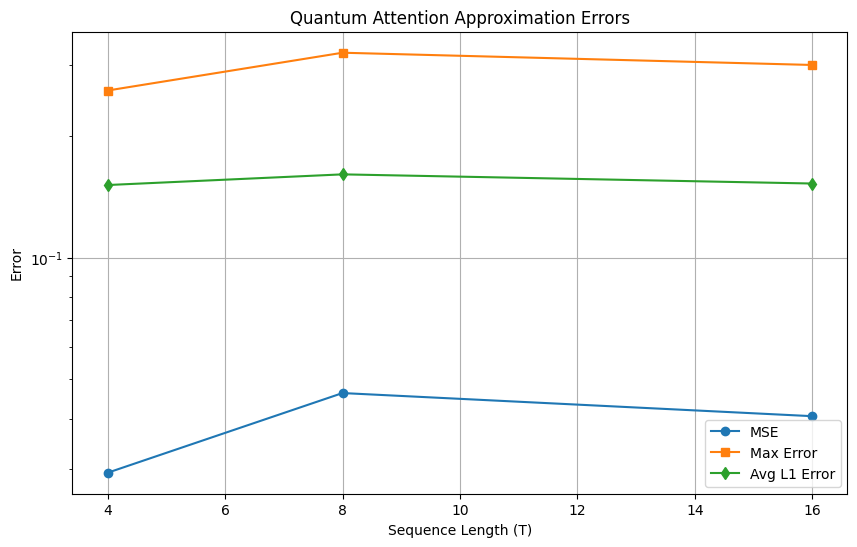

In [29]:
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import math
import pandas as pd

# Fix seed
np.random.seed(42)

# ---------------------------------------------------------------------
# 2. Define all subroutines (UPDATED)
# ---------------------------------------------------------------------
def poly_exp_approx(scores, degree=3):
    s = onp.array(scores, dtype=float)
    a, b = s.min(), s.max()
    t = (2*s - (b + a)) / (b - a)
    M = 100
    nodes = onp.cos((2*onp.arange(M)+1)/(2*M)*onp.pi)
    xs = ((b - a)*nodes + (b + a)) / 2
    ys = onp.exp(xs)
    coeffs = onp.polynomial.chebyshev.chebfit(nodes, ys, deg=degree)
    return onp.polynomial.chebyshev.chebval(t, coeffs)

def amplitude_encode(vec, wires):
    vec = np.array(vec, float)
    norm = np.linalg.norm(vec)
    qml.AmplitudeEmbedding(features=vec/norm, wires=wires, normalize=False)

def make_hadamard_qnode(n_data):
    dev = qml.device("default.qubit", wires=n_data+1)
    @qml.qnode(dev)
    def hadamard_test(Uq, Uk):
        anc = n_data
        qml.Hadamard(wires=anc)
        def W():
            Uq(); qml.adjoint(Uk)()
        qml.ctrl(W, control=anc)()
        qml.Hadamard(wires=anc)
        return qml.expval(qml.PauliZ(wires=anc))
    return hadamard_test

def overlap(hadamard_test, q_vec, k_vec, n_data):
    def Uq(): amplitude_encode(q_vec, wires=range(n_data))
    def Uk(): amplitude_encode(k_vec, wires=range(n_data))
    return hadamard_test(Uq, Uk)

def run_attention_pipeline(X, poly_degree=3):
    T, d = X.shape
    # 1) Prepare subroutines
    n_data = int(math.ceil(math.log2(d)))
    hadamard_test = make_hadamard_qnode(n_data)

    # 2) Q/K/V all = X
    Q_data = K_data = V_data = X

    # 3) quantum scores
    scores = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            scores[i,j] = overlap(hadamard_test, Q_data[i], K_data[j], n_data)

    # 4) polynomial‐approx softmax
    exp_approx = poly_exp_approx(scores.flatten(), degree=poly_degree).reshape(T,T)
    w_q = exp_approx / np.sum(exp_approx, axis=1, keepdims=True)

    # 5) classical softmax
    def softmax_row(r):
        e = onp.exp(r - onp.max(r))
        return e/np.sum(e)
    w_cl = onp.vstack([softmax_row(onp.array(scores[i])) for i in range(T)])

    # 6) CORRECTED: Classical mixed state probabilities
    classical_mixed_probs = np.zeros((T, d))
    for i in range(T):
        for k in range(d):
            # ∑ⱼ w_j |v_j,k|² (matches quantum mixed state)
            classical_mixed_probs[i,k] = np.sum(w_q[i] * V_data[:,k]**2)

    # 7) Quantum mixed state probabilities
    n_index = int(math.ceil(math.log2(T)))
    agg_dev = qml.device("default.qubit", wires=n_index + n_data)
    @qml.qnode(agg_dev)
    def agg_circuit(weights, V_states):
        idx = list(range(n_index))
        data = list(range(n_index, n_index+n_data))
        amp = np.sqrt(weights)
        qml.AmplitudeEmbedding(features=amp/np.linalg.norm(amp),
                               wires=idx, normalize=True)
        for j in range(T):
            def Uvj(): amplitude_encode(V_states[j], wires=data)
            ctrl_bin = format(j, f"0{n_index}b")
            qml.ctrl(Uvj, control=idx, control_values=ctrl_bin)()
        return qml.state()

    quant_probs = []
    for i in range(T):
        state = agg_circuit(w_q[i].tolist(), V_data.tolist())
        ρ = onp.outer(state, onp.conj(state))
        # Partial‐trace over index
        data_rho = onp.zeros((2**n_data, 2**n_data), complex)
        for a in range(2**n_data):
            for b in range(2**n_data):
                for k in range(2**n_index):
                    idx_in = k*2**n_data + a
                    jdx_in = k*2**n_data + b
                    data_rho[a,b] += ρ[idx_in, jdx_in]
        quant_probs.append(onp.real(onp.diag(data_rho)))
    quant_probs = onp.vstack(quant_probs)  # T x 2**n_data

    # 8) Pad quantum results to original d dimensions
    quant_padded = np.zeros((T, d))
    for i in range(T):
        quant_padded[i, :len(quant_probs[i])] = quant_probs[i][:d]

    return classical_mixed_probs, quant_padded

# ---------------------------------------------------------------------
# 3. Sweep over different T, compute error metrics (UPDATED)
# ---------------------------------------------------------------------
results = []
iris = load_iris().data
for T_val in [4, 8, 16]:
    # pick first T_val rows, normalize
    Xsub = normalize(iris[:T_val], axis=1)
    cl_p, q_p = run_attention_pipeline(Xsub, poly_degree=3)

    # Calculate errors for all tokens
    mse = onp.mean((q_p - cl_p)**2)
    maxe = onp.max(onp.abs(q_p - cl_p))
    l1  = onp.sum(onp.abs(q_p - cl_p)) / (T_val * Xsub.shape[1])  # Average L1 per element

    results.append({
        "T": T_val,
        "MSE": mse,
        "MaxErr": maxe,
        "AvgL1": l1,
        "AvgClassicalProb": onp.mean(cl_p),
        "AvgQuantumProb": onp.mean(q_p)
    })

df = pd.DataFrame(results)
print(df)

# ---------------------------------------------------------------------
# 4. Plot errors vs T
# ---------------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Error metrics
plt.plot(df["T"], df["MSE"], 'o-', label='MSE')
plt.plot(df["T"], df["MaxErr"], 's-', label='Max Error')
plt.plot(df["T"], df["AvgL1"], 'd-', label='Avg L1 Error')
plt.yscale('log')
plt.xlabel("Sequence Length (T)")
plt.ylabel("Error")
plt.title("Quantum Attention Approximation Errors")
plt.legend()
plt.grid(True)



# ---------------------------------------------------------------------
# 5. Error source analysis (NEW)
# ---------------------------------------------------------------------
print("\nError Sources Analysis:")
print("1. Polynomial approximation of softmax (degree=3)")
print("2. Limited qubits for amplitude encoding (log2(d) qubits)")
print("3. Quantum circuit noise/sampling (simulated perfectly)")
print("4. Truncation of quantum state (d < 2**n_data)")
print("5. Hadamard test precision")